In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from minisom import MiniSom
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import psutil
import warnings
import tracemalloc


In [2]:
# Inizializzazione del dataset e dei parametri
DATA_PATH = "/users/mik2002/som/dataset-processed UNSW-NB15/"
FILES_Train = ["training_processed.csv"]
FILES_Test = ["testing_processed.csv"]
df_train = pd.concat([pd.read_csv(DATA_PATH + file) for file in FILES_Train], ignore_index=True)
df_test = pd.concat([pd.read_csv(DATA_PATH + file) for file in FILES_Test], ignore_index=True)


In [3]:
# Droppare la colonna 'attack_cat'
df_train = df_train.drop(columns=['attack_cat'])
df_test = df_test.drop(columns=['attack_cat'])

# Verifica delle colonne
print("Columns in df_train:", df_train.columns)
print("Columns in df_test:", df_test.columns)

# split dataset in data and target 
target_train = df_train['label'].values
data_train = df_train.drop(columns=['label'])

# split dataset in data and target 
target_test = df_test['label'].values
data_test = df_test.drop(columns=['label'])

print("Training set has {} samples.".format(data_train.shape[0]))
print("Testing set has {} samples.".format(data_test.shape[0]))


Columns in df_train: Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'ct_src_ltm', 'ct_srv_dst',
       'proto_tcp', 'proto_udp', 'proto_unas', 'proto_arp', 'proto_ospf',
       'proto_sctp', 'proto_others', 'service_http', 'service_irc',
       'service_pop3', 'service_radius', 'service_smtp', 'service_snmp',
       'service_ssh', 'service_ssl', 'service_others', 'state_ACC',
       'state_CLO', 'state_CON', 'state_ECO', 'state_FIN', 'state_INT',
       'state_PAR', 'state_REQ', 'state_RST', 'state_URN', 'state_-',
       'state_others', 'label'],
      dtype='object')
Columns in df_test: Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'ct_src_ltm', 'ct_srv_dst',
       'pro

In [4]:

# since this is supervised classification not unsupervised, this function chooses the class of
# the BMU to be the final class of each instance
def classify(som, data):
    """Classifies each sample in data in one of the classes defined
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(data_train.values, target_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result


In [5]:

# set hyperparameters
n_neurons = 20
m_neurons = 20
input_len = data_train.shape[1]
sigma = 1.5
learning_rate = 1.2
iterations = 10000


In [6]:

# initialization
som = MiniSom(x=n_neurons, y=m_neurons, input_len=input_len, sigma=sigma, learning_rate=learning_rate)
som.random_weights_init(data_train.values)


In [7]:

# Train the SOM
som.train(data_train.values, 1, verbose=True, use_epochs=True)  # Ensure to pass numpy array


 [    729 / 175341 ]   0% - 0:00:48 left 

 [ 175341 / 175341 ] 100% - 0:00:00 left 
 quantization error: 3.4581509201099974


In [8]:
# Classification
y_pred = classify(som, data_test.values)

# Report
report = classification_report(target_test, y_pred, digits=4)
print(report)


              precision    recall  f1-score   support

           0     0.7515    0.5068    0.6053     37000
           1     0.6820    0.8632    0.7619     45332

    accuracy                         0.7030     82332
   macro avg     0.7167    0.6850    0.6836     82332
weighted avg     0.7132    0.7030    0.6916     82332



KeyboardInterrupt: 

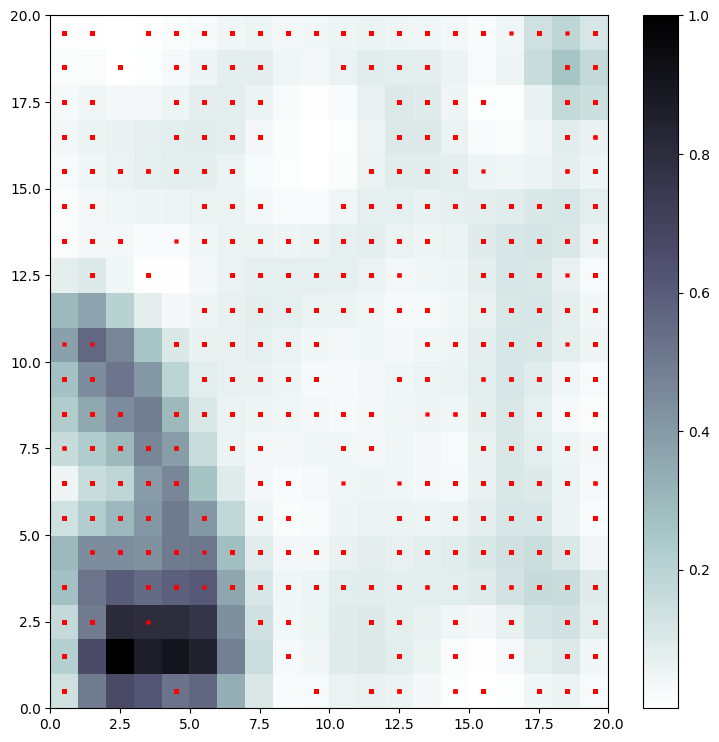

In [9]:

# Plotting
plt.figure(figsize=(9, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the processed dataset
# different colors and markers for each label
markers = ['o', 's']
colors = ['g', 'r']

for cnt, xx in enumerate(data_test.values):  # Use data_test.values here
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx
    plt.plot(w[0] + .5, w[1] + .5, markers[target_test[cnt]], markerfacecolor=colors[target_test[cnt]],
             markeredgecolor=colors[target_test[cnt]], markersize=1, markeredgewidth=2)

plt.show()
